# Mount Drive for the Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


# Coarse-to-Fine Strategy

Baseline L->R ...
Baseline R->L ...
LR consistency mask ...
Computing census...
Computing gradients...
Running block-based hybrid refinement ...
Refinement complete: changed 4168 pixels in 19.55s (block=11, R=2)
Pixels that worsened GT (y,x,d0,best_d,gt,e_before,e_after) — should be empty:
(143, 965, 19, 20, np.float32(19.367188), np.float32(0.3671875), np.float32(0.6328125))
(143, 966, 19, 20, np.float32(17.9375), np.float32(1.0625), np.float32(2.0625))
(144, 967, 19, 20, np.float32(17.972656), np.float32(1.0273438), np.float32(2.0273438))
(144, 977, 20, 19, np.float32(19.976562), np.float32(0.0234375), np.float32(0.9765625))
(150, 747, 4, 3, np.float32(5.796875), np.float32(1.796875), np.float32(2.796875))
(153, 522, 6, 7, np.float32(6.4414062), np.float32(0.44140625), np.float32(0.55859375))
(153, 530, 5, 3, np.float32(6.2929688), np.float32(1.2929688), np.float32(3.2929688))
(154, 277, 17, 18, np.float32(17.3125), np.float32(0.3125), np.float32(0.6875))
(154, 745, 4, 3, np.float32(

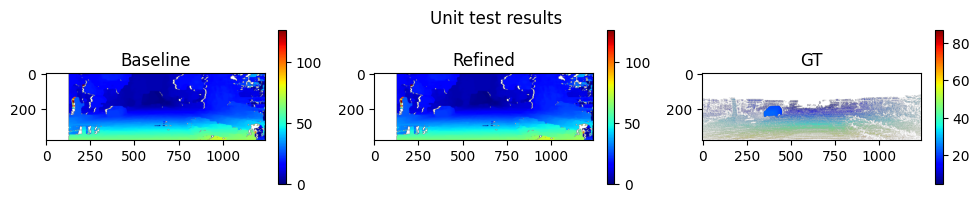

In [4]:
"""
Block-based hybrid cost
- Baseline: StereoBM or StereoSGBM
- Refinement: per-pixel local search around baseline integer disparity
  using hybrid cost = wc*census_norm + wi*intensity_patch_norm + wg*grad_patch_norm
  (intensity and gradient use block SAD/mean over block_size)
- Strict fallback: accept only if new cost + eps < baseline cost
- Proper right->left baseline for LR-consistency
- Need-to-refine mask and plotting
- Debug option to print any pixels that worsen GT (should be none)

Requirements:
    pip install opencv-python numpy matplotlib
"""

import os
import time
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from itertools import product

# -----------------------------
# Utility functions
# -----------------------------
def load_gray(path):
    im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if im is None:
        raise FileNotFoundError(f"Could not load: {path}")
    return im

# -----------------------------
# Census transform (uint64)
# -----------------------------
def census_transform(img, window=7):
    assert window % 2 == 1, "window must be odd"
    h, w = img.shape
    r = window // 2
    img_p = np.pad(img, r, mode='reflect').astype(np.uint8)
    desc = np.zeros((h, w), dtype=np.uint64)
    bit_pos = 0
    for dy in range(-r, r+1):
        for dx in range(-r, r+1):
            if dy == 0 and dx == 0:
                continue
            neigh = img_p[r + dy : r + dy + h, r + dx : r + dx + w]
            bit = (neigh < img).astype(np.uint64)
            desc |= (bit << bit_pos)
            bit_pos += 1
    return desc

# -----------------------------
# Gradients
# -----------------------------
def compute_gradients(img):
    gx = cv2.Sobel(img.astype(np.float32), cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(img.astype(np.float32), cv2.CV_32F, 0, 1, ksize=3)
    return np.sqrt(gx*gx + gy*gy)

# -----------------------------
# Popcount
# -----------------------------
def popcount_int(x):
    return int(int(x).bit_count())

# -----------------------------
# Block-based hybrid cost (normalized)
# -----------------------------
def hybrid_cost_block(cL, cR, IL, IR, GL, GR,
                      x, xr, y,
                      block_r,
                      max_census_bits,
                      max_intensity=255.0,
                      max_grad=1.0,
                      wc=1.0, wi=1.0, wg=1.0):
    """
    Compute normalized hybrid cost over patches centered at (x,y) and (xr,y)
      - census: popcount(xor) / max_census_bits
      - intensity: mean(|patchL - patchR|) / max_intensity
      - gradient: mean(|patchG_L - patchG_R|) / max_grad (clipped to 1)
    Returns weighted sum: wc*c + wi*i + wg*g
    """
    h, w = IL.shape
    r = block_r
    # patch bounds (ensure within image)
    y0 = max(0, y - r); y1 = min(h, y + r + 1)
    x0 = max(0, x - r); x1 = min(w, x + r + 1)
    xr0 = max(0, xr - r); xr1 = min(w, xr + r + 1)

    # If patches shapes differ due to border clipping, align by cropping both to same size
    phL = IL[y0:y1, x0:x1]
    phR = IR[y0:y1, xr0:xr1]
    # If shapes differ, crop to smallest common region from top-left
    min_h = min(phL.shape[0], phR.shape[0])
    min_w = min(phL.shape[1], phR.shape[1])
    if min_h == 0 or min_w == 0:
        # degenerate at extreme border
        return float('inf')

    phL = phL[:min_h, :min_w].astype(np.float32)
    phR = phR[:min_h, :min_w].astype(np.float32)

    # intensity mean absolute difference normalized
    i_sad = np.mean(np.abs(phL - phR)) / max_intensity

    # gradient patches
    pgL = GL[y0:y1, x0:x1][:min_h, :min_w].astype(np.float32)
    pgR = GR[y0:y1, xr0:xr1][:min_h, :min_w].astype(np.float32)
    g_sad = np.mean(np.abs(pgL - pgR)) / max_grad
    g_sad = min(g_sad, 1.0)

    # census popcount (center pixels only — census descriptor encodes neighbourhood)
    xor = int(cL[y, x]) ^ int(cR[y, xr])
    c_pc = popcount_int(xor)
    c_norm = c_pc / float(max_census_bits) if max_census_bits > 0 else float(c_pc)

    return wc * c_norm + wi * i_sad + wg * g_sad

# -----------------------------
# StereoRefiner (full corrected)
# -----------------------------
class StereoRefiner:
    def __init__(self, left, right, gt=None, census_win=7, baseline_method='sgbm'):
        self.left = left
        self.right = right
        self.h, self.w = left.shape
        self.gt = gt
        self.census_win = census_win
        self.baseline_method = baseline_method.lower()

        # lazy buffers
        self.censusL = None
        self.censusR = None
        self.gradL = None
        self.gradR = None

        self.disp_baseline = None
        self.disp_baseline_R2L = None

        self.max_census_bits = (census_win * census_win) - 1

    def compute_baseline(self, num_disp=128, block_size=11, store=True):
        num_disp = max(16, (num_disp // 16) * 16)
        if self.baseline_method == 'bm':
            bm = cv2.StereoBM_create(numDisparities=num_disp, blockSize=block_size)
            raw = bm.compute(self.left, self.right)
        else:
            matcher = cv2.StereoSGBM_create(minDisparity=0, numDisparities=num_disp,
                                            blockSize=block_size,
                                            P1=8*1*block_size*block_size,
                                            P2=32*1*block_size*block_size,
                                            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
            raw = matcher.compute(self.left, self.right)
        disp = raw.astype(np.float32) / 16.0
        disp[disp < 0] = np.nan
        if store:
            self.disp_baseline = disp
        return disp

    def compute_baseline_R2L(self, num_disp=128, block_size=11, store=True):
        num_disp = max(16, (num_disp // 16) * 16)
        if self.baseline_method == 'bm':
            bm = cv2.StereoBM_create(numDisparities=num_disp, blockSize=block_size)
            raw = bm.compute(self.right, self.left)
        else:
            matcher = cv2.StereoSGBM_create(minDisparity=0, numDisparities=num_disp,
                                            blockSize=block_size,
                                            P1=8*1*block_size*block_size,
                                            P2=32*1*block_size*block_size,
                                            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
            raw = matcher.compute(self.right, self.left)
        disp = raw.astype(np.float32) / 16.0
        disp[disp < 0] = np.nan
        if store:
            self.disp_baseline_R2L = disp
        return disp

    def compute_features(self):
        if self.censusL is None:
            print("Computing census...")
            self.censusL = census_transform(self.left, window=self.census_win)
            self.censusR = census_transform(self.right, window=self.census_win)
        if self.gradL is None:
            print("Computing gradients...")
            self.gradL = compute_gradients(self.left)
            self.gradR = compute_gradients(self.right)

    def compute_lr_consistency(self, dispL, dispR, thresh=1.0):
        mask = np.zeros((self.h, self.w), dtype=bool)
        for y in range(self.h):
            for x in range(self.w):
                d = float(dispL[y, x])
                if np.isnan(d):
                    continue
                xr = int(round(x - d))
                if 0 <= xr < self.w:
                    d_r = float(dispR[y, xr])
                    if not np.isnan(d_r) and abs(d - d_r) <= thresh:
                        mask[y, x] = True
        return mask

    def build_need_refine_mask(self, disp_int, percentile=75, grad_thresh=10.0):
        self.compute_features()
        h, w = self.h, self.w
        cost_map = np.full((h, w), 255, dtype=np.uint8)
        unique_ds = np.unique(disp_int)
        for d in unique_ds:
            if d < 0:
                continue
            ys, xs = np.nonzero(disp_int == d)
            if ys.size == 0:
                continue
            xr = xs - d
            valid = (xr >= 0) & (xr < w)
            if not np.any(valid):
                continue
            ys_v = ys[valid]; xs_v = xs[valid]; xr_v = xr[valid]
            vals = []
            for yi, xi, xri in zip(ys_v, xs_v, xr_v):
                xor = int(self.censusL[yi, xi]) ^ int(self.censusR[yi, xri])
                vals.append(popcount_int(xor))
            cost_map[ys_v, xs_v] = np.array(vals, dtype=np.uint8)
        valid_costs = cost_map[cost_map != 255]
        thr_cost = 255 if valid_costs.size == 0 else np.percentile(valid_costs, percentile)
        gx = cv2.Sobel(self.left.astype(np.float32), cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(self.left.astype(np.float32), cv2.CV_32F, 0, 1, ksize=3)
        grad = np.sqrt(gx*gx + gy*gy)
        need = (cost_map > thr_cost) | (grad > grad_thresh)
        need = need & (~np.isnan(disp_int).astype(bool))
        return need

    def refine_hybrid_local(self, disp0, block_size=11, R=3, wc=1.0, wi=1.0, wg=1.0,
                            need_mask=None, lr_consistency=None, max_grad_percentile=99.0,
                            max_disp_allowed=256, debug=False):
        """
        Block-based hybrid refinement.

        block_size: should match baseline block_size for intensity/gradient comparison.
        R: search radius around baseline integer disparity
        wc,wi,wg: weights after normalization
        """
        t0 = time.time()
        self.compute_features()
        h, w = self.h, self.w
        block_r = block_size // 2
        # gradient normalization constant
        max_grad = np.nanpercentile(self.gradL, max_grad_percentile)
        if max_grad <= 0:
            max_grad = 1.0

        # prepare baseline integer disparity (floor), mark invalid as -1
        disp0_int = np.full_like(disp0, -1, dtype=np.int32)
        valid_mask = ~np.isnan(disp0)
        disp0_int[valid_mask] = np.floor(disp0[valid_mask]).astype(np.int32)

        refined = disp0.copy()

        # precompute baseline hybrid cost (block-based) where possible
        base_cost = np.full((h, w), np.inf, dtype=np.float32)
        for y in range(h):
            for x in range(w):
                if not valid_mask[y, x]:
                    continue
                d0i = int(disp0_int[y, x])
                xr0 = x - d0i
                if xr0 < 0 or xr0 >= w:
                    continue
                base_cost[y, x] = hybrid_cost_block(self.censusL, self.censusR,
                                                    self.left, self.right,
                                                    self.gradL, self.gradR,
                                                    x, xr0, y,
                                                    block_r,
                                                    max_census_bits=self.max_census_bits,
                                                    max_intensity=255.0,
                                                    max_grad=max_grad,
                                                    wc=wc, wi=wi, wg=wg)
        changes = 0
        eps = 1e-9
        bad_debug_list = []
        for y in range(h):
            for x in range(w):
                if not valid_mask[y, x]:
                    continue
                if need_mask is not None and not need_mask[y, x]:
                    continue
                if lr_consistency is not None and not lr_consistency[y, x]:
                    continue

                d0i = int(disp0_int[y, x])
                if d0i < 0:
                    continue
                dmin = max(0, d0i - R)
                dmax = min(int(max_disp_allowed), d0i + R)

                best_d = d0i
                best_cost = base_cost[y, x]
                if not np.isfinite(best_cost):
                    xr0 = x - d0i
                    if xr0 < 0 or xr0 >= w:
                        continue
                    best_cost = hybrid_cost_block(self.censusL, self.censusR,
                                                  self.left, self.right,
                                                  self.gradL, self.gradR,
                                                  x, xr0, y,
                                                  block_r, self.max_census_bits,
                                                  max_intensity=255.0, max_grad=max_grad,
                                                  wc=wc, wi=wi, wg=wg)
                # search neighbors
                for d in range(dmin, dmax + 1):
                    xr = x - d
                    if xr < 0 or xr >= w:
                        continue
                    cost = hybrid_cost_block(self.censusL, self.censusR,
                                             self.left, self.right,
                                             self.gradL, self.gradR,
                                             x, xr, y,
                                             block_r, self.max_census_bits,
                                             max_intensity=255.0, max_grad=max_grad,
                                             wc=wc, wi=wi, wg=wg)
                    if cost + eps < best_cost:
                        best_cost = cost
                        best_d = d

                if best_d != d0i:
                    # optional debug: check GT effect
                    if self.gt is not None and not np.isnan(self.gt[y, x]):
                        e_before = abs(d0i - self.gt[y, x])
                        e_after = abs(best_d - self.gt[y, x])
                        if e_after > e_before + 1e-12:
                            bad_debug_list.append((y, x, d0i, best_d, self.gt[y, x], e_before, e_after))
                    refined[y, x] = float(best_d)
                    changes += 1
        t_total = time.time() - t0
        print(f"Refinement complete: changed {changes} pixels in {t_total:.2f}s (block={block_size}, R={R})")
        if debug and len(bad_debug_list) > 0:
            print("Pixels that worsened GT (y,x,d0,best_d,gt,e_before,e_after) — should be empty:")
            for i, entry in enumerate(bad_debug_list):
                if i >= 200:
                    break
                print(entry)
        return refined

    def evaluate_vs_gt(self, disp_pred):
        if self.gt is None:
            raise ValueError("GT not provided")
        mask = ~np.isnan(self.gt)
        diff = np.abs(disp_pred - self.gt)
        mae = np.nanmean(diff)
        rmse = np.sqrt(np.nanmean(diff**2))
        bad1 = np.mean((diff > 1.0)[mask]) * 100.0
        bad3 = np.mean((diff > 3.0)[mask]) * 100.0
        return {'MAE': mae, 'RMSE': rmse, 'Bad1%': bad1, 'Bad3%': bad3}

    def plot_results(self, disp_base, disp_refined, title='Results'):
        plt.figure(figsize=(12,2))
        plt.subplot(1,3,1); plt.title('Baseline'); plt.imshow(disp_base, cmap='jet'); plt.colorbar()
        plt.subplot(1,3,2); plt.title('Refined'); plt.imshow(disp_refined, cmap='jet'); plt.colorbar()
        if self.gt is not None:
            plt.subplot(1,3,3); plt.title('GT'); plt.imshow(self.gt, cmap='jet'); plt.colorbar()
        plt.suptitle(title)
        plt.show()

    def tune_weights_grid(self, disp0, need_mask=None, lr_mask=None, block_size=11, R=2,
                          wc_values=[1.0], wi_values=[1.0], wg_values=[0.5], max_disp_allowed=256):
        best = None
        results = []
        for wc, wi, wg in product(wc_values, wi_values, wg_values):
            print(f"Testing weights wc={wc}, wi={wi}, wg={wg}")
            t0 = time.time()
            refined = self.refine_hybrid_local(disp0, block_size=block_size, R=R, wc=wc, wi=wi, wg=wg,
                                               need_mask=need_mask, lr_consistency=lr_mask,
                                               max_disp_allowed=max_disp_allowed)
            t = time.time() - t0
            stats = None
            if self.gt is not None:
                stats = self.evaluate_vs_gt(refined)
                print(" -> stats:", stats)
                results.append((wc, wi, wg, stats, t))
                if best is None or stats['MAE'] < best[3]['MAE']:
                    best = (wc, wi, wg, stats, t)
            else:
                results.append((wc, wi, wg, None, t))
        return best, results

# -----------------------------
# Unit test / demo
# -----------------------------
def unit_test_on_sample(left_path, right_path, gt_path=None, debug=False):
    left = load_gray(left_path)
    right = load_gray(right_path)
    gt = None
    if gt_path and os.path.exists(gt_path):
        gtr = cv2.imread(gt_path, cv2.IMREAD_UNCHANGED).astype(np.float32) / 256.0
        gtr[gtr <= 0] = np.nan
        gt = gtr

    sr = StereoRefiner(left, right, gt=gt, census_win=7, baseline_method='sgbm') #BM or SGBM

    print("Baseline L->R ...")
    disp0 = sr.compute_baseline(num_disp=128, block_size=11, store=True)
    print("Baseline R->L ...")
    dispR = sr.compute_baseline_R2L(num_disp=128, block_size=11, store=True)

    print("LR consistency mask ...")
    lr_mask = sr.compute_lr_consistency(disp0, dispR, thresh=1.0)

    # need-mask using integer baseline
    disp_int = np.full_like(disp0, -1, dtype=np.int32)
    valid_mask = ~np.isnan(disp0)
    disp_int[valid_mask] = np.floor(disp0[valid_mask]).astype(np.int32)
    sr.compute_features()
    need_mask = sr.build_need_refine_mask(disp_int, percentile=75, grad_thresh=8.0)

    print("Running block-based hybrid refinement ...")
    t0 = time.time()
    refined = sr.refine_hybrid_local(disp0, block_size=11, R=2, wc=1.0, wi=1.0, wg=0.7,
                                     need_mask=need_mask, lr_consistency=lr_mask, debug=debug)
    print("Refinement time:", time.time() - t0)

    if gt is not None:
        before = sr.evaluate_vs_gt(disp0)
        after = sr.evaluate_vs_gt(refined)
        print("Before:", before)
        print("After: ", after)
    sr.plot_results(disp0, refined, title='Unit test results')

# -----------------------------
# Main guard
# -----------------------------
if __name__ == '__main__':
    LEFT = 'Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_2/000157_10.png'
    RIGHT = 'Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_3/000157_10.png'
    GT = 'Fast-ACVNet-main/data/KITTI/KITTI_2015/training/disp_occ_0/000157_10.png'

    if os.path.exists(LEFT) and os.path.exists(RIGHT):
        unit_test_on_sample(LEFT, RIGHT, GT if os.path.exists(GT) else None, debug=True)
    else:
        print("Please set LEFT and RIGHT to valid image paths and run again.")


Baseline L->R ...
Baseline R->L ...
LR consistency mask ...
Computing census...
Computing gradients...
Running block-based hybrid refinement ...
Refinement complete: changed 615 pixels in 19.30s (block=15, R=5)
Refinement time: 19.298506498336792


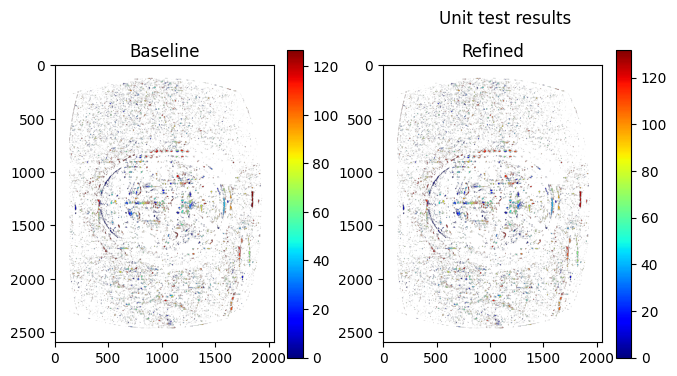

In [ ]:
"""
Block-based hybrid cost
- Baseline: StereoBM or StereoSGBM
- Refinement: per-pixel local search around baseline integer disparity
  using hybrid cost = wc*census_norm + wi*intensity_patch_norm + wg*grad_patch_norm
  (intensity and gradient use block SAD/mean over block_size)
- Strict fallback: accept only if new cost + eps < baseline cost
- Proper right->left baseline for LR-consistency
- Need-to-refine mask and plotting
- Debug option to print any pixels that worsen GT (should be none)

Requirements:
    pip install opencv-python numpy matplotlib
"""

import os
import time
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from itertools import product

# -----------------------------
# Utility functions
# -----------------------------
def load_gray(path):
    im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if im is None:
        raise FileNotFoundError(f"Could not load: {path}")
    return im

# -----------------------------
# Census transform (uint64)
# -----------------------------
def census_transform(img, window=5):
    assert window % 2 == 1, "window must be odd"
    h, w = img.shape
    r = window // 2
    img_p = np.pad(img, r, mode='reflect').astype(np.uint8)
    desc = np.zeros((h, w), dtype=np.uint64)
    bit_pos = 0
    for dy in range(-r, r+1):
        for dx in range(-r, r+1):
            if dy == 0 and dx == 0:
                continue
            neigh = img_p[r + dy : r + dy + h, r + dx : r + dx + w]
            bit = (neigh < img).astype(np.uint64)
            desc |= (bit << bit_pos)
            bit_pos += 1
    return desc

# -----------------------------
# Gradients
# -----------------------------
def compute_gradients(img):
    gx = cv2.Sobel(img.astype(np.float32), cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(img.astype(np.float32), cv2.CV_32F, 0, 1, ksize=3)
    return np.sqrt(gx*gx + gy*gy)

# -----------------------------
# Popcount
# -----------------------------
def popcount_int(x):
    return int(int(x).bit_count())

# -----------------------------
# Block-based hybrid cost (normalized)
# -----------------------------
def hybrid_cost_block(cL, cR, IL, IR, GL, GR,
                      x, xr, y,
                      block_r,
                      max_census_bits,
                      max_intensity=255.0,
                      max_grad=1.0,
                      wc=0.4, wi=0.2, wg=0.4):
    """
    Compute normalized hybrid cost over patches centered at (x,y) and (xr,y)
      - census: popcount(xor) / max_census_bits
      - intensity: mean(|patchL - patchR|) / max_intensity
      - gradient: mean(|patchG_L - patchG_R|) / max_grad (clipped to 1)
    Returns weighted sum: wc*c + wi*i + wg*g
    """
    h, w = IL.shape
    r = block_r
    # patch bounds (ensure within image)
    y0 = max(0, y - r); y1 = min(h, y + r + 1)
    x0 = max(0, x - r); x1 = min(w, x + r + 1)
    xr0 = max(0, xr - r); xr1 = min(w, xr + r + 1)

    # If patches shapes differ due to border clipping, align by cropping both to same size
    phL = IL[y0:y1, x0:x1]
    phR = IR[y0:y1, xr0:xr1]
    # If shapes differ, crop to smallest common region from top-left
    min_h = min(phL.shape[0], phR.shape[0])
    min_w = min(phL.shape[1], phR.shape[1])
    if min_h == 0 or min_w == 0:
        # degenerate at extreme border
        return float('inf')

    phL = phL[:min_h, :min_w].astype(np.float32)
    phR = phR[:min_h, :min_w].astype(np.float32)

    # intensity mean absolute difference normalized
    i_sad = np.mean(np.abs(phL - phR)) / max_intensity

    # gradient patches
    pgL = GL[y0:y1, x0:x1][:min_h, :min_w].astype(np.float32)
    pgR = GR[y0:y1, xr0:xr1][:min_h, :min_w].astype(np.float32)
    g_sad = np.mean(np.abs(pgL - pgR)) / max_grad
    g_sad = min(g_sad, 1.0)

    # census popcount (center pixels only — census descriptor encodes neighbourhood)
    xor = int(cL[y, x]) ^ int(cR[y, xr])
    c_pc = popcount_int(xor)
    c_norm = c_pc / float(max_census_bits) if max_census_bits > 0 else float(c_pc)

    return wc * c_norm + wi * i_sad + wg * g_sad

# -----------------------------
# StereoRefiner (full corrected)
# -----------------------------
class StereoRefiner:
    def __init__(self, left, right, gt=None, census_win=7, baseline_method='sgbm'):
        self.left = left
        self.right = right
        self.h, self.w = left.shape
        self.gt = gt
        self.census_win = census_win
        self.baseline_method = baseline_method.lower()

        # lazy buffers
        self.censusL = None
        self.censusR = None
        self.gradL = None
        self.gradR = None

        self.disp_baseline = None
        self.disp_baseline_R2L = None

        self.max_census_bits = (census_win * census_win) - 1

    def compute_baseline(self, num_disp=128, block_size=15, store=True):
        num_disp = max(16, (num_disp // 16) * 16)
        if self.baseline_method == 'bm':
            bm = cv2.StereoBM_create(numDisparities=num_disp, blockSize=block_size)
            raw = bm.compute(self.left, self.right)
        else:
            matcher = cv2.StereoSGBM_create(minDisparity=0, numDisparities=num_disp,
                                            blockSize=block_size,
                                            P1=8*1*block_size*block_size,
                                            P2=32*1*block_size*block_size,
                                            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
            raw = matcher.compute(self.left, self.right)
        disp = raw.astype(np.float32) / 16.0
        disp[disp < 0] = np.nan
        if store:
            self.disp_baseline = disp
        return disp

    def compute_baseline_R2L(self, num_disp=128, block_size=15, store=True):
        num_disp = max(16, (num_disp // 16) * 16)
        if self.baseline_method == 'bm':
            bm = cv2.StereoBM_create(numDisparities=num_disp, blockSize=block_size)
            raw = bm.compute(self.right, self.left)
        else:
            matcher = cv2.StereoSGBM_create(minDisparity=0, numDisparities=num_disp,
                                            blockSize=block_size,
                                            P1=8*1*block_size*block_size,
                                            P2=32*1*block_size*block_size,
                                            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
            raw = matcher.compute(self.right, self.left)
        disp = raw.astype(np.float32) / 16.0
        disp[disp < 0] = np.nan
        if store:
            self.disp_baseline_R2L = disp
        return disp

    def compute_features(self):
        if self.censusL is None:
            print("Computing census...")
            self.censusL = census_transform(self.left, window=self.census_win)
            self.censusR = census_transform(self.right, window=self.census_win)
        if self.gradL is None:
            print("Computing gradients...")
            self.gradL = compute_gradients(self.left)
            self.gradR = compute_gradients(self.right)

    def compute_lr_consistency(self, dispL, dispR, thresh=1.0):
        mask = np.zeros((self.h, self.w), dtype=bool)
        for y in range(self.h):
            for x in range(self.w):
                d = float(dispL[y, x])
                if np.isnan(d):
                    continue
                xr = int(round(x - d))
                if 0 <= xr < self.w:
                    d_r = float(dispR[y, xr])
                    if not np.isnan(d_r) and abs(d - d_r) <= thresh:
                        mask[y, x] = True
        return mask

    def build_need_refine_mask(self, disp_int, percentile=75, grad_thresh=10.0):
        self.compute_features()
        h, w = self.h, self.w
        cost_map = np.full((h, w), 255, dtype=np.uint8)
        unique_ds = np.unique(disp_int)
        for d in unique_ds:
            if d < 0:
                continue
            ys, xs = np.nonzero(disp_int == d)
            if ys.size == 0:
                continue
            xr = xs - d
            valid = (xr >= 0) & (xr < w)
            if not np.any(valid):
                continue
            ys_v = ys[valid]; xs_v = xs[valid]; xr_v = xr[valid]
            vals = []
            for yi, xi, xri in zip(ys_v, xs_v, xr_v):
                xor = int(self.censusL[yi, xi]) ^ int(self.censusR[yi, xri])
                vals.append(popcount_int(xor))
            cost_map[ys_v, xs_v] = np.array(vals, dtype=np.uint8)
        valid_costs = cost_map[cost_map != 255]
        thr_cost = 255 if valid_costs.size == 0 else np.percentile(valid_costs, percentile)
        gx = cv2.Sobel(self.left.astype(np.float32), cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(self.left.astype(np.float32), cv2.CV_32F, 0, 1, ksize=3)
        grad = np.sqrt(gx*gx + gy*gy)
        need = (cost_map > thr_cost) | (grad > grad_thresh)
        need = need & (~np.isnan(disp_int).astype(bool))
        return need

    def refine_hybrid_local(self, disp0, block_size=15, R=5, wc=0.4, wi=0.2, wg=0.4,
                            need_mask=None, lr_consistency=None, max_grad_percentile=99.0,
                            max_disp_allowed=256, debug=False):
        """
        Block-based hybrid refinement.

        block_size: should match baseline block_size for intensity/gradient comparison.
        R: search radius around baseline integer disparity
        wc,wi,wg: weights after normalization
        """
        t0 = time.time()
        self.compute_features()
        h, w = self.h, self.w
        block_r = block_size // 2
        # gradient normalization constant
        max_grad = np.nanpercentile(self.gradL, max_grad_percentile)
        if max_grad <= 0:
            max_grad = 1.0

        # prepare baseline integer disparity (floor), mark invalid as -1
        disp0_int = np.full_like(disp0, -1, dtype=np.int32)
        valid_mask = ~np.isnan(disp0)
        disp0_int[valid_mask] = np.floor(disp0[valid_mask]).astype(np.int32)

        refined = disp0.copy()

        # precompute baseline hybrid cost (block-based) where possible
        base_cost = np.full((h, w), np.inf, dtype=np.float32)
        for y in range(h):
            for x in range(w):
                if not valid_mask[y, x]:
                    continue
                d0i = int(disp0_int[y, x])
                xr0 = x - d0i
                if xr0 < 0 or xr0 >= w:
                    continue
                base_cost[y, x] = hybrid_cost_block(self.censusL, self.censusR,
                                                    self.left, self.right,
                                                    self.gradL, self.gradR,
                                                    x, xr0, y,
                                                    block_r,
                                                    max_census_bits=self.max_census_bits,
                                                    max_intensity=255.0,
                                                    max_grad=max_grad,
                                                    wc=wc, wi=wi, wg=wg)
        changes = 0
        eps = 1e-9
        bad_debug_list = []
        for y in range(h):
            for x in range(w):
                if not valid_mask[y, x]:
                    continue
                if need_mask is not None and not need_mask[y, x]:
                    continue
                if lr_consistency is not None and not lr_consistency[y, x]:
                    continue

                d0i = int(disp0_int[y, x])
                if d0i < 0:
                    continue
                dmin = max(0, d0i - R)
                dmax = min(int(max_disp_allowed), d0i + R)

                best_d = d0i
                best_cost = base_cost[y, x]
                if not np.isfinite(best_cost):
                    xr0 = x - d0i
                    if xr0 < 0 or xr0 >= w:
                        continue
                    best_cost = hybrid_cost_block(self.censusL, self.censusR,
                                                  self.left, self.right,
                                                  self.gradL, self.gradR,
                                                  x, xr0, y,
                                                  block_r, self.max_census_bits,
                                                  max_intensity=255.0, max_grad=max_grad,
                                                  wc=wc, wi=wi, wg=wg)
                # search neighbors
                for d in range(dmin, dmax + 1):
                    xr = x - d
                    if xr < 0 or xr >= w:
                        continue
                    cost = hybrid_cost_block(self.censusL, self.censusR,
                                             self.left, self.right,
                                             self.gradL, self.gradR,
                                             x, xr, y,
                                             block_r, self.max_census_bits,
                                             max_intensity=255.0, max_grad=max_grad,
                                             wc=wc, wi=wi, wg=wg)
                    if cost + eps < best_cost:
                        best_cost = cost
                        best_d = d

                if best_d != d0i:
                    # optional debug: check GT effect
                    if self.gt is not None and not np.isnan(self.gt[y, x]):
                        e_before = abs(d0i - self.gt[y, x])
                        e_after = abs(best_d - self.gt[y, x])
                        if e_after > e_before + 1e-12:
                            bad_debug_list.append((y, x, d0i, best_d, self.gt[y, x], e_before, e_after))
                    refined[y, x] = float(best_d)
                    changes += 1
        t_total = time.time() - t0
        print(f"Refinement complete: changed {changes} pixels in {t_total:.2f}s (block={block_size}, R={R})")
        if debug and len(bad_debug_list) > 0:
            print("Pixels that worsened GT (y,x,d0,best_d,gt,e_before,e_after) — should be empty:")
            for i, entry in enumerate(bad_debug_list):
                if i >= 200:
                    break
                print(entry)
        return refined

    def evaluate_vs_gt(self, disp_pred):
      """
      Compute evaluation metrics against disparity ground-truth.

      Metrics:
      - MAE  : Mean Absolute Error
      - SD   : Standard deviation of absolute error
      - RMSE : Root Mean Square Error
      - SAD  : Sum of Absolute Differences
      - SSD  : Sum of Squared Differences
      - Bad3 : % pixels with abs error > 3 px
      - Bad5 : % pixels with abs error > 5 px
      """

      if self.gt is None:
          raise ValueError("GT not provided")

      # Mask valid GT pixels
      mask = ~np.isnan(self.gt)
      diff = np.abs(disp_pred - self.gt)

      # Basic
      mae = np.nanmean(diff)
      sd  = np.nanstd(diff)
      rmse = np.sqrt(np.nanmean(diff**2))

      # Aggregated error sums
      sad = np.nansum(diff)
      ssd = np.nansum(diff**2)

      # Bad pixel rates
      bad3 = np.mean((diff > 3.0)[mask]) * 100.0
      bad5 = np.mean((diff > 5.0)[mask]) * 100.0

      return {
          'MAE': mae,
          'SD': sd,
          'RMSE': rmse,
          'SAD': sad,
          'SSD': ssd,
          'Bad3%': bad3,
          'Bad5%': bad5
      }


    def plot_results(self, disp_base, disp_refined, title='Results'):
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.title('Baseline'); plt.imshow(disp_base, cmap='jet'); plt.colorbar()
        plt.subplot(1,3,2); plt.title('Refined'); plt.imshow(disp_refined, cmap='jet'); plt.colorbar()
        if self.gt is not None:
            plt.subplot(1,3,3); plt.title('GT'); plt.imshow(self.gt, cmap='jet'); plt.colorbar()
        plt.suptitle(title)
        plt.show()

    def tune_weights_grid(self, disp0, need_mask=None, lr_mask=None, block_size=11, R=2,
                          wc_values=[0.4], wi_values=[0.2], wg_values=[0.4], max_disp_allowed=256):
        best = None
        results = []
        for wc, wi, wg in product(wc_values, wi_values, wg_values):
            print(f"Testing weights wc={wc}, wi={wi}, wg={wg}")
            t0 = time.time()
            refined = self.refine_hybrid_local(disp0, block_size=block_size, R=R, wc=wc, wi=wi, wg=wg,
                                               need_mask=need_mask, lr_consistency=lr_mask,
                                               max_disp_allowed=max_disp_allowed)
            t = time.time() - t0
            stats = None
            if self.gt is not None:
                stats = self.evaluate_vs_gt(refined)
                print(" -> stats:", stats)
                results.append((wc, wi, wg, stats, t))
                if best is None or stats['MAE'] < best[3]['MAE']:
                    best = (wc, wi, wg, stats, t)
            else:
                results.append((wc, wi, wg, None, t))
        return best, results

# -----------------------------
# New helper utilities for plotting and depth
# -----------------------------
def disparity_to_depth(disp, baseline=0.54, focal=721.0):
    """
    Convert disparity map (in pixels) to depth in meters using:
        depth = (baseline * focal) / disparity
    Handles NaNs and zeros safely by leaving them as NaN.
    """
    depth = np.full_like(disp, np.nan, dtype=np.float32)
    # valid disparity > 0 and not nan
    valid = (disp > 0) & (~np.isnan(disp))
    depth[valid] = (baseline * focal) / disp[valid]
    return depth

def compute_error_map(disp, gt):
    """
    Compute absolute error map |disp - gt|; preserve NaNs from gt.
    """
    err = np.abs(disp - gt)
    err[np.isnan(gt)] = np.nan
    return err

def plot_full_comparison(disp_base, disp_refined,
                         depth_base, depth_refined,
                         err_base, err_refined,
                         vmin_disp=None, vmax_disp=None,
                         save_dir="ComparisonRows"):
    """
    Plots the 3×2 comparison AND saves each row separately.

        [ disp_base      | disp_refined   ]
        [ err_base       | err_refined    ]
        [ depth_base     | depth_refined  ]
    """
    name = "Demo1"
    os.makedirs(save_dir, exist_ok=True)

    # ----------------------------------------------------
    # Shared normalization
    # ----------------------------------------------------
    if vmin_disp is None:
        vmin_disp = np.nanmin([np.nanmin(disp_base), np.nanmin(disp_refined)])
    if vmax_disp is None:
        vmax_disp = np.nanmax([np.nanmax(disp_base), np.nanmax(disp_refined)])

    vmax_err = np.nanmax([np.nanmax(err_base), np.nanmax(err_refined)])
    vmax_err = max(vmax_err, 1.0)

    vmax_depth = np.nanpercentile(
        np.concatenate([depth_base.flatten(), depth_refined.flatten()]),
        99
    )

    # ----------------------------------------------------
    # Full 3×2 Figure
    #-----------------------------------------------------
    fig, axes = plt.subplots(3, 2, figsize=(14, 6))

    # Row 1
    ax = axes[0, 0]
    im = ax.imshow(disp_base, cmap="plasma", vmin=vmin_disp, vmax=vmax_disp)
    ax.set_title("Baseline Disparity", fontsize=10, pad=4)
    ax.axis("off")
    fig.colorbar(im, ax=ax, pad=0.01, fraction=0.04)

    ax = axes[0, 1]
    im = ax.imshow(disp_refined, cmap="plasma", vmin=vmin_disp, vmax=vmax_disp)
    ax.set_title("Refined Disparity", fontsize=10, pad=4)
    ax.axis("off")
    fig.colorbar(im, ax=ax, pad=0.01, fraction=0.04)

    # # Row 2
    # ax = axes[1, 0]
    # im = ax.imshow(err_base, cmap="hot", vmin=0, vmax=vmax_err)
    # ax.set_title("Baseline Error", fontsize=10, pad=4)
    # ax.axis("off")
    # fig.colorbar(im, ax=ax, pad=0.01, fraction=0.04)

    # ax = axes[1, 1]
    # im = ax.imshow(err_refined, cmap="hot", vmin=0, vmax=vmax_err)
    # ax.set_title("Refined Error", fontsize=10, pad=4)
    # ax.axis("off")
    # fig.colorbar(im, ax=ax, pad=0.01, fraction=0.04)

    # Row 3
    ax = axes[2, 0]
    im = ax.imshow(depth_base, cmap="viridis", vmin=0, vmax=vmax_depth)
    ax.set_title("Baseline Depth", fontsize=10, pad=4)
    ax.axis("off")
    fig.colorbar(im, ax=ax, pad=0.01, fraction=0.04)

    ax = axes[2, 1]
    im = ax.imshow(depth_refined, cmap="viridis", vmin=0, vmax=vmax_depth)
    ax.set_title("Refined Depth", fontsize=10, pad=4)
    ax.axis("off")
    fig.colorbar(im, ax=ax, pad=0.01, fraction=0.04)

    plt.subplots_adjust(wspace=0.12, hspace=0.25)
    plt.show()

    # ----------------------------------------------------
    # SAVE ROW 1
    # ----------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    ax = axes[0]
    im = ax.imshow(disp_base, cmap="plasma", vmin=vmin_disp, vmax=vmax_disp)
    ax.set_title("Baseline Disparity", fontsize=10)
    ax.axis("off")
    fig.colorbar(im, ax=ax, pad=0.01, fraction=0.04)

    ax = axes[1]
    im = ax.imshow(disp_refined, cmap="plasma", vmin=vmin_disp, vmax=vmax_disp)
    ax.set_title("Refined Disparity", fontsize=10)
    ax.axis("off")
    fig.colorbar(im, ax=ax, pad=0.01, fraction=0.04)

    plt.tight_layout()
    plt.savefig(f"{save_dir}/"+name+"row1_disparities.png", dpi=300, bbox_inches="tight")
    plt.close()

    # ----------------------------------------------------
    # SAVE ROW 2
    # ----------------------------------------------------
    # fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    # ax = axes[0]
    # im = ax.imshow(err_base, cmap="hot", vmin=0, vmax=vmax_err)
    # ax.set_title("Baseline Error", fontsize=10)
    # ax.axis("off")
    # fig.colorbar(im, ax=ax, pad=0.01, fraction=0.04)

    # ax = axes[1]
    # im = ax.imshow(err_refined, cmap="hot", vmin=0, vmax=vmax_err)
    # ax.set_title("Refined Error", fontsize=10)
    # ax.axis("off")
    # fig.colorbar(im, ax=ax, pad=0.01, fraction=0.04)

    # plt.tight_layout()
    # plt.savefig(f"{save_dir}/"+name+"row2_errors.png", dpi=300, bbox_inches="tight")
    # plt.close()

    # ----------------------------------------------------
    # SAVE ROW 3
    # ----------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    ax = axes[0]
    im = ax.imshow(depth_base, cmap="viridis", vmin=0, vmax=vmax_depth)
    ax.set_title("Baseline Depth", fontsize=10)
    ax.axis("off")
    fig.colorbar(im, ax=ax, pad=0.01, fraction=0.04)

    ax = axes[1]
    im = ax.imshow(depth_refined, cmap="viridis", vmin=0, vmax=vmax_depth)
    ax.set_title("Refined Depth", fontsize=10)
    ax.axis("off")
    fig.colorbar(im, ax=ax, pad=0.01, fraction=0.04)

    plt.tight_layout()
    plt.savefig(f"{save_dir}/"+name+"row3_depth.png", dpi=300, bbox_inches="tight")
    plt.close()

    print(f"Saved row images to: {save_dir}")

# -----------------------------
# Unit test / demo
# -----------------------------
def unit_test_on_sample(left_path, right_path, gt_path=None, debug=False):
    left = load_gray(left_path)
    right = load_gray(right_path)
    gt = None
    if gt_path and os.path.exists(gt_path):
        gtr = cv2.imread(gt_path, cv2.IMREAD_UNCHANGED).astype(np.float32) / 256.0
        gtr[gtr <= 0] = np.nan
        gt = gtr

    sr = StereoRefiner(left, right, gt=gt, census_win=5, baseline_method='bm')

    print("Baseline L->R ...")
    disp0 = sr.compute_baseline(num_disp=128, block_size=15, store=True)
    print("Baseline R->L ...")
    dispR = sr.compute_baseline_R2L(num_disp=128, block_size=15, store=True)

    print("LR consistency mask ...")
    lr_mask = sr.compute_lr_consistency(disp0, dispR, thresh=1.0)

    # need-mask using integer baseline
    disp_int = np.full_like(disp0, -1, dtype=np.int32)
    valid_mask = ~np.isnan(disp0)
    disp_int[valid_mask] = np.floor(disp0[valid_mask]).astype(np.int32)
    sr.compute_features()
    need_mask = sr.build_need_refine_mask(disp_int, percentile=75, grad_thresh=8.0)

    print("Running block-based hybrid refinement ...")
    t0 = time.time()
    refined = sr.refine_hybrid_local(disp0, block_size=15, R=5, wc=0.4, wi=0.2, wg=0.4,
                                     need_mask=need_mask, lr_consistency=lr_mask, debug=debug)
    print("Refinement time:", time.time() - t0)

    # ---------- Replaced block: produce disparity, error, and depth visualizations ----------
    if gt is not None:
        # Error maps
        err_base = compute_error_map(disp0, gt)
        err_ref = compute_error_map(refined, gt)

        # Depth maps
        depth_base = disparity_to_depth(disp0, baseline=0.54, focal=721.0)
        depth_refined = disparity_to_depth(refined, baseline=0.54, focal=721.0)

        # Print metrics
        before = sr.evaluate_vs_gt(disp0)
        after = sr.evaluate_vs_gt(refined)
        print("Before:", before)
        print("After: ", after)

        # Choose reasonable display range for disparity using percentiles (ignores NaNs)
        valid_disp_vals = np.concatenate([np.nanpercentile(disp0, [2,98]), np.nanpercentile(refined, [2,98])])
        vmin_disp = float(np.min(valid_disp_vals))
        vmax_disp = float(np.max(valid_disp_vals))

        # Full visualization
        plot_full_comparison(
            disp0, refined,
            depth_base, depth_refined,
            err_base, err_ref,
            vmin_disp=vmin_disp, vmax_disp=vmax_disp
        )
    else:
        # Only disparity maps (no GT)
        sr.plot_results(disp0, refined, title='Unit test results')

# -----------------------------
# Main guard
# -----------------------------
if __name__ == '__main__':
    # LEFT = 'Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_2/000157_10.png'
    # RIGHT = 'Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_3/000157_10.png'
    # GT = 'Fast-ACVNet-main/data/KITTI/KITTI_2015/training/disp_occ_0/000157_10.png'

    LEFT = 'Fast-ACVNet-main/data/resample/ROT_TOP_left.jpg'
    RIGHT = 'Fast-ACVNet-main/data/resample/ROT_BOT_right.jpg'
    GT = ""

    if os.path.exists(LEFT) and os.path.exists(RIGHT):
        unit_test_on_sample(LEFT, RIGHT, GT if os.path.exists(GT) else None, debug=True)
    else:
        print("Please set LEFT and RIGHT to valid image paths and run again.")


# KITTI Datatest

## Block Matching

### Testing

Image shape: (374, 1238) (374, 1238) (374, 1238)


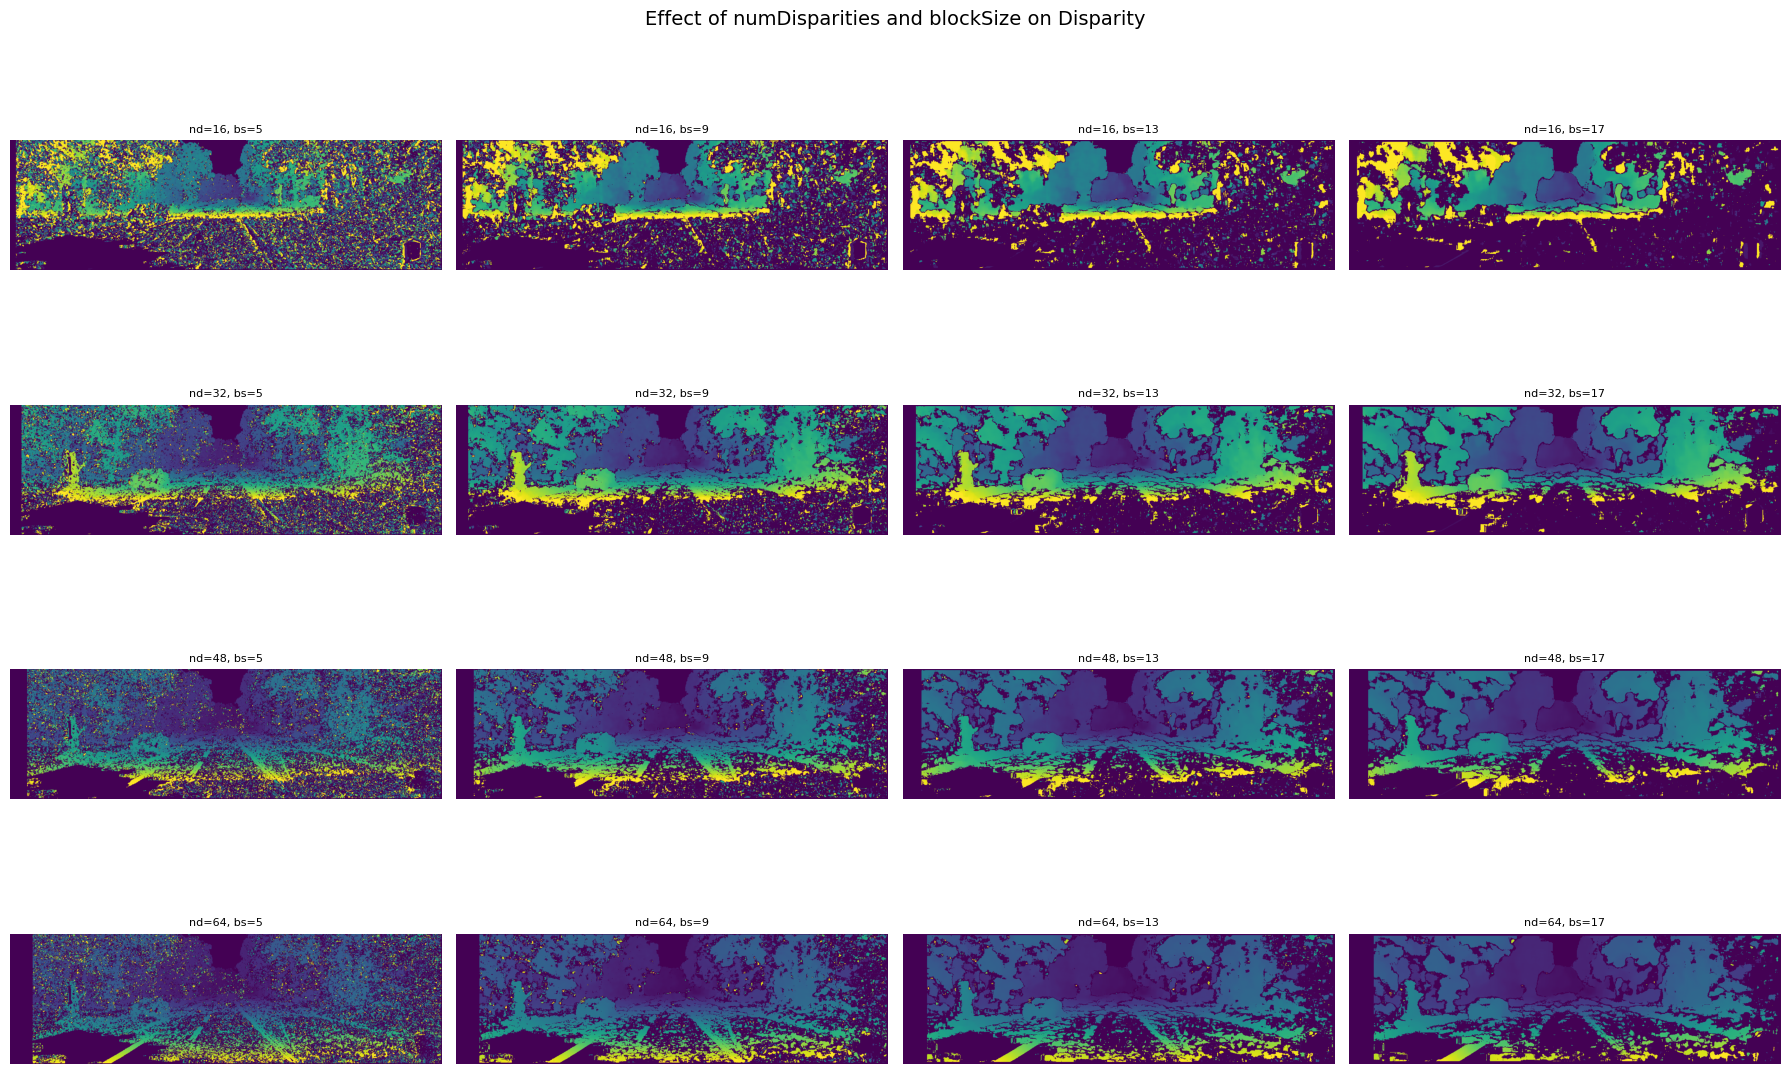


📊 StereoBM KITTI Evaluation (000157_10)
 numDisp | blockSize |  MAE(px) |  STD(px) |   RMS(px) |   Bad3(%) |  Bad5(%) |     SAD
----------|------------|----------|-----------|------------|-----------|----------|----------
      16 |          5 |   27.514 |    17.803 |     32.772 |     86.35 |    85.19 | 2836245.8
      16 |          9 |   28.697 |    18.129 |     33.943 |     84.77 |    83.86 | 2958118.2
      16 |         13 |   29.455 |    18.156 |     34.601 |     84.65 |    83.78 | 3036299.5
      16 |         17 |   29.864 |    18.033 |     34.886 |     85.32 |    84.34 | 3078476.8
      32 |          5 |   22.547 |    20.632 |     30.562 |     64.98 |    63.68 | 2324152.8
      32 |          9 |   22.606 |    21.905 |     31.478 |     58.47 |    57.68 | 2330256.5
      32 |         13 |   23.336 |    22.130 |     32.161 |     58.99 |    58.39 | 2405505.2
      32 |         17 |   24.099 |    21.928 |     32.582 |     61.61 |    60.90 | 2484143.8
      48 |          5 |   20.050 

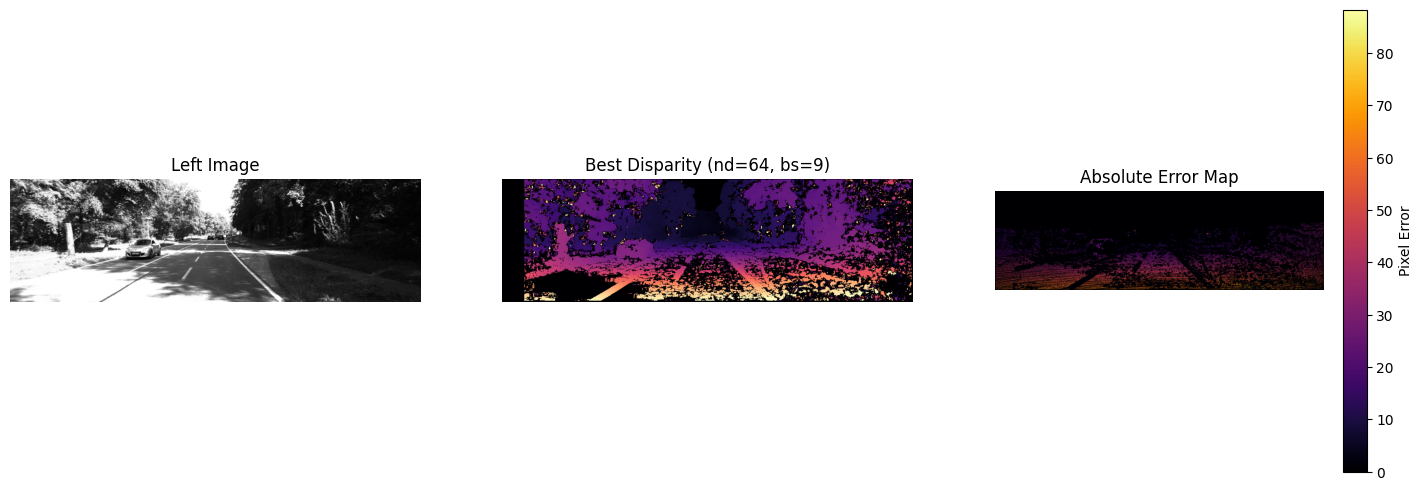

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

# ==============================
# 1. Load KITTI stereo image pair + ground truth
# ==============================

left_path = "Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_2/000157_10.png"
right_path = "Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_3/000157_10.png"
gt_path = "Fast-ACVNet-main/data/KITTI/KITTI_2015/training/disp_occ_0/000157_10.png"

imgL = cv.imread(left_path, cv.IMREAD_GRAYSCALE)
imgR = cv.imread(right_path, cv.IMREAD_GRAYSCALE)
gt_disp = cv.imread(gt_path, cv.IMREAD_UNCHANGED)

if imgL is None or imgR is None or gt_disp is None:
    raise FileNotFoundError("Images or ground truth not found. Check your paths!")

print("Image shape:", imgL.shape, imgR.shape, gt_disp.shape)

# KITTI scaling and valid mask
gt_disp = gt_disp.astype(np.float32) / 256.0
mask = gt_disp > 0

# ==============================
# 2. Parameter ranges
# ==============================
num_disp_values = [16, 32, 48, 64]   # multiples of 16
block_size_values = [5, 9, 13, 17]   # odd numbers only

# ==============================
# 3. Loop: compute disparities and errors
# ==============================
results = []

for nd in num_disp_values:
    for bs in block_size_values:
        stereo = cv.StereoBM_create(numDisparities=nd, blockSize=bs)
        stereo.setMinDisparity(0)
        disparity = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

        # Error metrics
        abs_error = np.abs(disparity[mask] - gt_disp[mask])
        mae = np.mean(abs_error)
        std = np.std(abs_error)
        sad = np.sum(abs_error)
        rms = np.sqrt(np.mean((disparity[mask] - gt_disp[mask]) ** 2))
        bad3 = np.mean(abs_error > 3.0) * 100
        bad5 = np.mean(abs_error > 5.0) * 100

        results.append({
            "numDisp": nd,
            "blockSize": bs,
            "MAE": mae,
            "STD": std,
            "SAD": sad,
            "RMS": rms,
            "Bad3": bad3,
            "Bad5": bad5,
            "disp": disparity
        })

# ==============================
# 4. Display disparity maps
# ==============================
plt.figure(figsize=(18, 12))
plot_index = 1
for r in results:
    plt.subplot(len(num_disp_values), len(block_size_values), plot_index)
    plt.imshow(r["disp"], cmap='viridis')
    plt.axis('off')
    plt.title(f'nd={r["numDisp"]}, bs={r["blockSize"]}', fontsize=8)
    plot_index += 1

plt.suptitle("Effect of numDisparities and blockSize on Disparity", fontsize=14)
plt.tight_layout()
plt.show()

# ==============================
# 5. Print metrics summary
# ==============================
print("\n📊 StereoBM KITTI Evaluation (000157_10)")
print(" numDisp | blockSize |  MAE(px) |  STD(px) |   RMS(px) |   Bad3(%) |  Bad5(%) |     SAD")
print("----------|------------|----------|-----------|------------|-----------|----------|----------")
for r in results:
    print(f"{r['numDisp']:8d} | {r['blockSize']:10d} | {r['MAE']:8.3f} | {r['STD']:9.3f} | {r['RMS']:10.3f} |"
          f" {r['Bad3']:9.2f} | {r['Bad5']:8.2f} | {r['SAD']:8.1f}")

# ==============================
# 6. Visualize best configuration (lowest MAE)
# ==============================
best = min(results, key=lambda x: x['MAE'])
print("\n✅ Best Configuration:")
print(f"numDisparities = {best['numDisp']}, blockSize = {best['blockSize']}")
print(f"MAE = {best['MAE']:.4f} px, STD = {best['STD']:.4f} px, RMS = {best['RMS']:.4f} px, Bad3 = {best['Bad3']:.2f}%")

# Error map visualization
abs_error_full = np.abs(best['disp'] - gt_disp)
error_map = np.zeros_like(gt_disp)
error_map[mask] = abs_error_full[mask]

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(imgL, cmap='gray')
plt.title("Left Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(best["disp"], cmap='magma')
plt.title(f"Best Disparity (nd={best['numDisp']}, bs={best['blockSize']})")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(error_map, cmap='inferno')
plt.title("Absolute Error Map")
plt.colorbar(label='Pixel Error')
plt.axis('off')
plt.show()


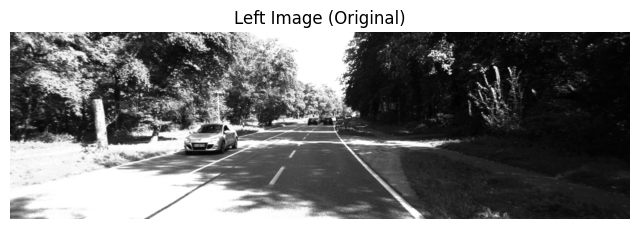

interactive(children=(IntSlider(value=10, description='thresh', max=50), IntSlider(value=15, description='uniq…

<function __main__.update(thresh=10, uniq=15, speckleW=24, speckleR=16, pfSize=9, pfCap=31, minD=-32, numD=32, bSize=11)>

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# --- Load KITTI image pair and ground truth ---
imgL = cv.imread("Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_2/000157_10.png", cv.IMREAD_GRAYSCALE)
imgR = cv.imread("Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_3/000157_10.png", cv.IMREAD_GRAYSCALE)
gt_disp = cv.imread("Fast-ACVNet-main/data/KITTI/KITTI_2015/training/disp_occ_0/000157_10.png", cv.IMREAD_UNCHANGED)

if imgL is None or imgR is None or gt_disp is None:
    raise FileNotFoundError("Check file paths — one or more images not found!")

# Convert KITTI disparity to float (divide by 256)
gt_disp = gt_disp.astype(np.float32) / 256.0
mask = gt_disp > 0  # valid disparity mask

plt.figure(figsize=(8,6))
plt.imshow(imgL, cmap='gray')
plt.title("Left Image (Original)")
plt.axis('off')
plt.show()

# --- Interactive update function ---
def update(thresh=10, uniq=15, speckleW=24, speckleR=16, pfSize=9, pfCap=31, minD=-32, numD=32, bSize=11):
    # Ensure valid StereoBM constraints
    if numD % 16 != 0:
        numD = (numD // 16) * 16
    if bSize % 2 == 0:
        bSize += 1

    stereo = cv.StereoBM.create(numDisparities=numD, blockSize=bSize)
    stereo.setMinDisparity(minD)
    stereo.setTextureThreshold(thresh)
    stereo.setUniquenessRatio(uniq)
    stereo.setSpeckleWindowSize(speckleW)
    stereo.setSpeckleRange(speckleR)
    stereo.setPreFilterSize(pfSize)
    stereo.setPreFilterCap(pfCap)

    # Compute disparity map
    disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

    # Compute error metrics vs ground truth
    abs_error = np.abs(disp[mask] - gt_disp[mask])
    mae = np.mean(abs_error)
    std = np.std(abs_error)
    rms = np.sqrt(np.mean((disp[mask] - gt_disp[mask])**2))
    sad = np.sum(abs_error)
    bad3 = np.mean(abs_error > 3.0) * 100
    bad5 = np.mean(abs_error > 5.0) * 100

    # Print metrics
    print(f"📊 Stereo Evaluation Metrics")
    print(f"numDisp={numD}, blockSize={bSize}, minDisp={minD}")
    print(f"TextureThresh={thresh}, Uniqueness={uniq}, SpeckleW={speckleW}, SpeckleR={speckleR}")
    print(f"PreFilterSize={pfSize}, PreFilterCap={pfCap}")
    print(f"-----------------------------------------")
    print(f"MAE:   {mae:.4f} px")
    print(f"STD:   {std:.4f} px")
    print(f"RMS:   {rms:.4f} px")
    print(f"SAD:   {sad:.2f}")
    print(f"Bad-3: {bad3:.2f}%   |   Bad-5: {bad5:.2f}%")

    # --- Visualization ---
    abs_error_full = np.abs(disp - gt_disp)
    error_map = np.zeros_like(gt_disp)
    error_map[mask] = abs_error_full[mask]

    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.imshow(disp, cmap='magma')
    plt.title("Computed Disparity")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(gt_disp, cmap='magma')
    plt.title("Ground Truth Disparity")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(error_map, cmap='inferno')
    plt.title("Absolute Error Map")
    plt.colorbar(label='Pixel Error')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- Interactive sliders ---
interact(
    update,
    thresh=(0, 50, 1),
    uniq=(0, 30, 2),
    speckleW=(0, 200, 2),
    speckleR=(0, 600, 5),
    pfSize=(5, 21, 2),
    pfCap=(1, 63, 1),
    minD=(-128, 128, 16),
    numD=(16, 256, 16),
    bSize=(5, 31, 2)
)



### Final Results

Image shape: (374, 1238) (374, 1238)
GT disparity dtype: uint16
==== StereoBM Performance ====
MAE  : 0.791 px
RMSE : 2.224 px
Bad 3-px Error: 1.92%


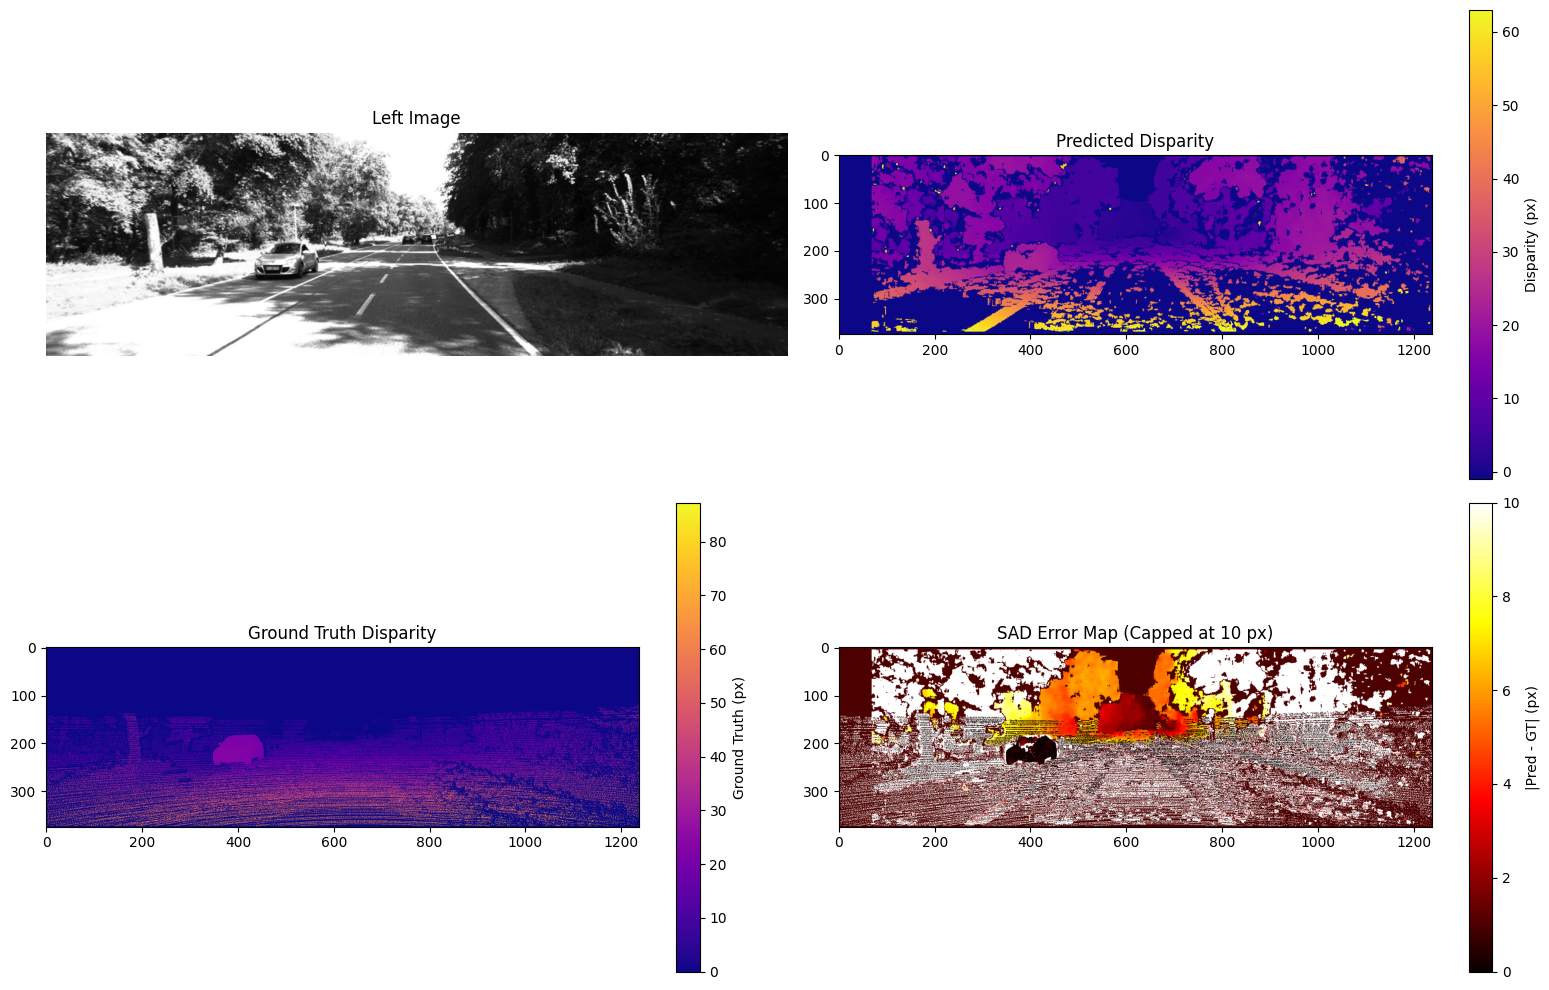

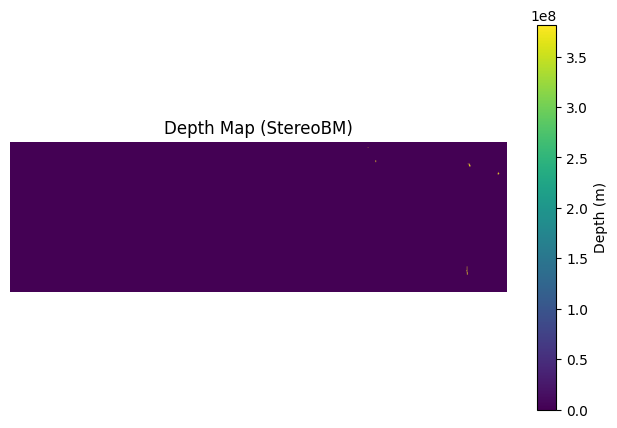

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

# ================================
# 1. Load KITTI stereo image pair
# ================================
left_path = "Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_2/000157_10.png"
right_path = "Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_3/000157_10.png"
gt_path = "Fast-ACVNet-main/data/KITTI/KITTI_2015/training/disp_occ_0/000157_10.png"

imgL = cv.imread(left_path, cv.IMREAD_GRAYSCALE)
imgR = cv.imread(right_path, cv.IMREAD_GRAYSCALE)
gt_disp = cv.imread(gt_path, cv.IMREAD_UNCHANGED)

if imgL is None or imgR is None or gt_disp is None:
    raise FileNotFoundError("Images or ground truth not found. Check your paths!")

print("Image shape:", imgL.shape, imgR.shape)
print("GT disparity dtype:", gt_disp.dtype)

# KITTI disparity ground truth is stored in uint16 with scaling factor 256
gt_disp = gt_disp.astype(np.float32) / 256.0

# =====================================
# 2. Stereo matcher (BM)
# =====================================
window_size = 11
num_disp = 64  # must be multiple of 16

stereo = cv.StereoBM.create(numDisparities=num_disp, blockSize=window_size)
stereo.setMinDisparity(0)
stereo.setTextureThreshold(0)
stereo.setUniquenessRatio(20)
stereo.setSpeckleWindowSize(9)
stereo.setSpeckleRange(50)
stereo.setPreFilterSize(9)
stereo.setPreFilterCap(31)

# =====================================
# 3. Compute disparity
# =====================================
disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

# =====================================
# 4. Compute depth (optional)
# =====================================
f = 707.0   # focal length (px)
B = 0.54    # baseline (m)
depth = f * B / (disp + 1e-6)  # avoid /0

# =====================================
# 5. Compute Error Maps & Metrics
# =====================================
mask = (gt_disp > 0) & (disp > 0)
abs_diff = np.abs(disp - gt_disp)
abs_diff_masked = abs_diff[mask]

mae = np.mean(abs_diff_masked)
rmse = np.sqrt(np.mean(abs_diff_masked**2))
bad3 = np.mean(abs_diff_masked > 3.0) * 100  # % of bad pixels (>3px)

print("==== StereoBM Performance ====")
print(f"MAE  : {mae:.3f} px")
print(f"RMSE : {rmse:.3f} px")
print(f"Bad 3-px Error: {bad3:.2f}%")

# =====================================
# 6. Visualization
# =====================================

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.imshow(imgL, cmap='gray')
plt.title("Left Image")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(disp, cmap='plasma')
plt.colorbar(label='Disparity (px)')
plt.title("Predicted Disparity")

plt.subplot(2, 2, 3)
plt.imshow(gt_disp, cmap='plasma')
plt.colorbar(label='Ground Truth (px)')
plt.title("Ground Truth Disparity")

plt.subplot(2, 2, 4)
plt.imshow(abs_diff, cmap='hot', vmax=10)
plt.colorbar(label='|Pred - GT| (px)')
plt.title("SAD Error Map (Capped at 10 px)")
plt.tight_layout()
plt.show()

# =====================================
# 7. Depth Map (optional)
# =====================================
plt.figure(figsize=(8, 5))
plt.imshow(depth, cmap='viridis')
plt.colorbar(label="Depth (m)")
plt.title("Depth Map (StereoBM)")
plt.axis('off')
plt.show()




# Semi Global Block Matching

### Testing

Image shapes: (374, 1238) (374, 1238) (374, 1238)


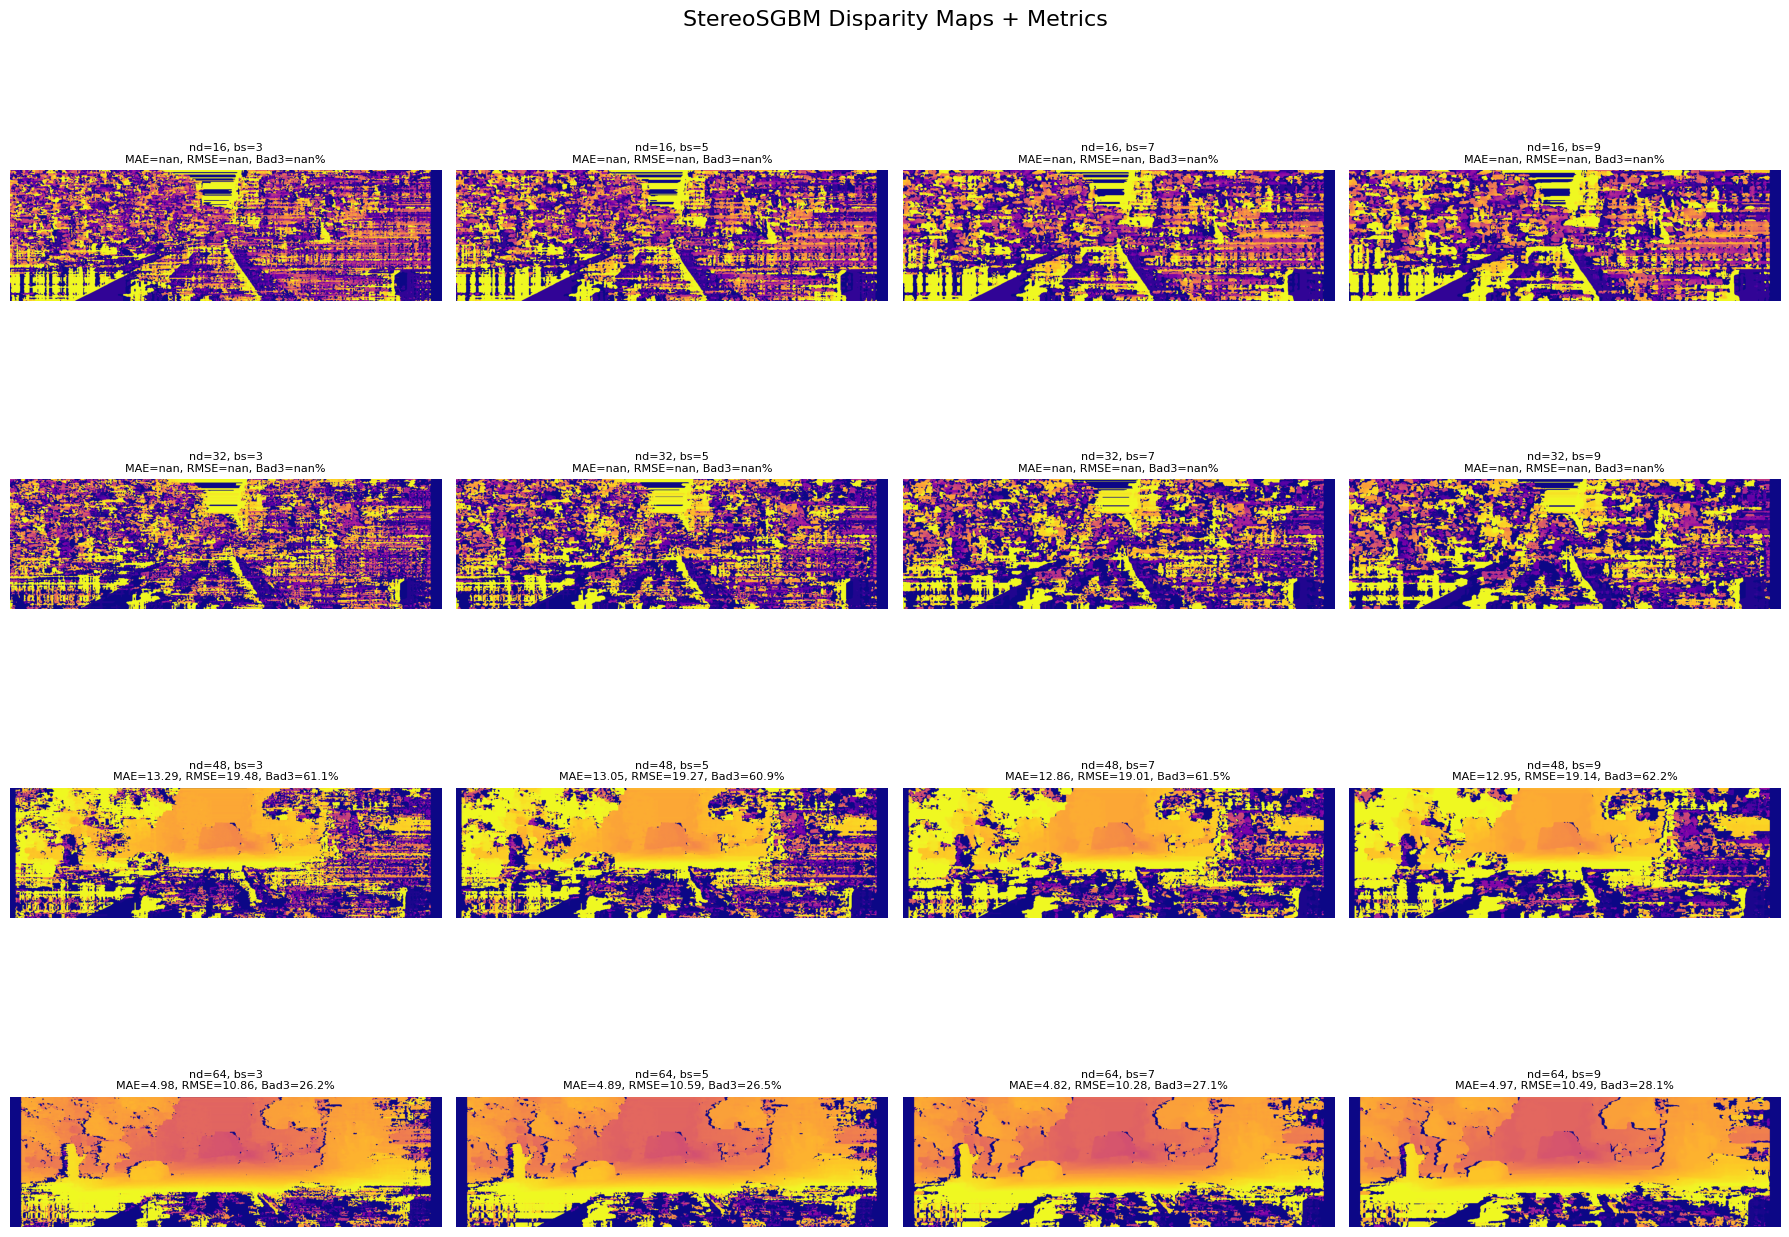


Best parameter set -> numDisp=64, blockSize=7


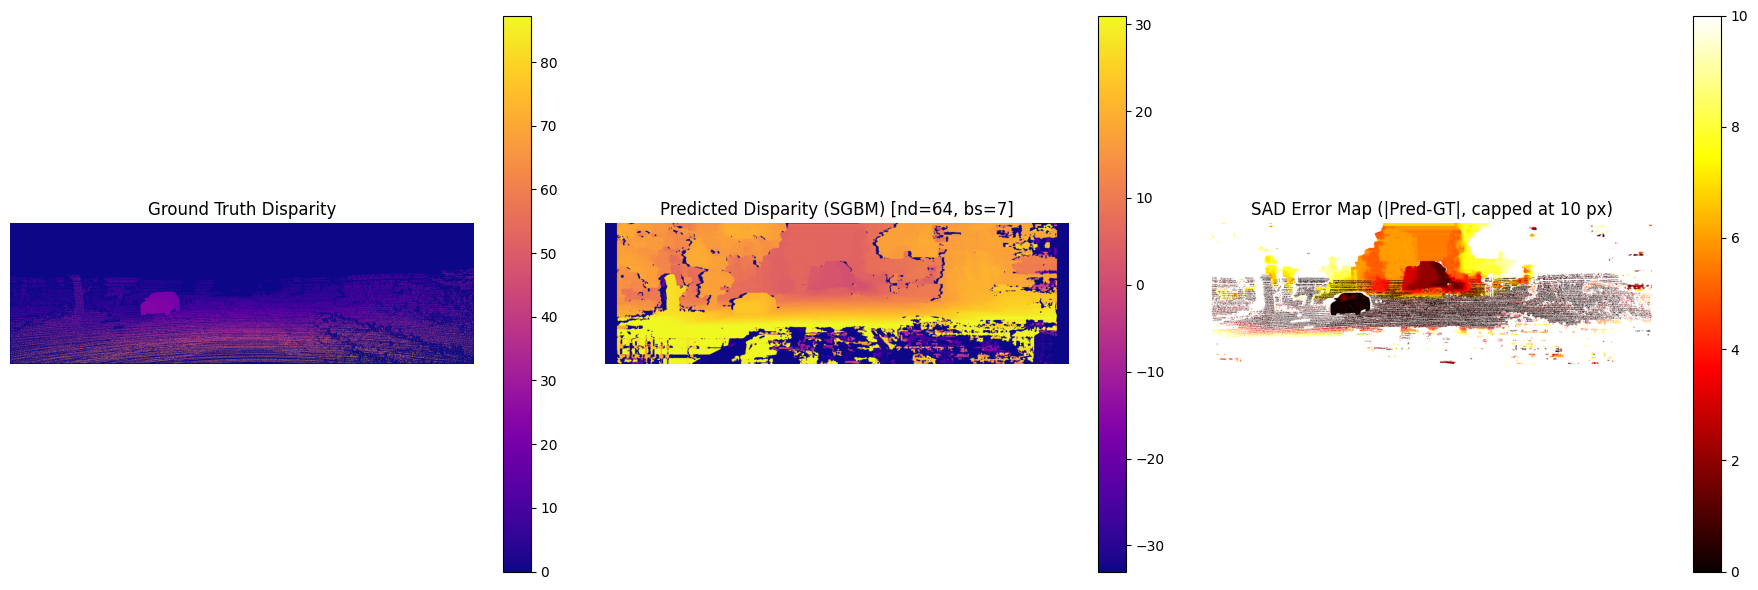


StereoSGBM Grid Search Metrics (KITTI 2015)
numDisp | blockSize |  MAE(px)  |  RMSE(px) | Bad3(%)
      16 |         3 |      nan |      nan |     nan
      16 |         5 |      nan |      nan |     nan
      16 |         7 |      nan |      nan |     nan
      16 |         9 |      nan |      nan |     nan
      32 |         3 |      nan |      nan |     nan
      32 |         5 |      nan |      nan |     nan
      32 |         7 |      nan |      nan |     nan
      32 |         9 |      nan |      nan |     nan
      48 |         3 |   13.294 |   19.479 |   61.09
      48 |         5 |   13.048 |   19.267 |   60.93
      48 |         7 |   12.864 |   19.006 |   61.52
      48 |         9 |   12.951 |   19.139 |   62.17
      64 |         3 |    4.983 |   10.858 |   26.16
      64 |         5 |    4.888 |   10.591 |   26.51
      64 |         7 |    4.822 |   10.276 |   27.14
      64 |         9 |    4.970 |   10.489 |   28.05


In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

# ==============================
# 1. Load KITTI stereo image pair
# ==============================
left_path = "Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_2/000157_10.png"
right_path = "Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_3/000157_10.png"
gt_path = "Fast-ACVNet-main/data/KITTI/KITTI_2015/training/disp_occ_0/000157_10.png"

imgL = cv.imread(left_path, cv.IMREAD_GRAYSCALE)
imgR = cv.imread(right_path, cv.IMREAD_GRAYSCALE)
gt_disp = cv.imread(gt_path, cv.IMREAD_UNCHANGED)

if imgL is None or imgR is None or gt_disp is None:
    raise FileNotFoundError("Images or ground truth not found. Check paths!")

print("Image shapes:", imgL.shape, imgR.shape, gt_disp.shape)

gt_disp = gt_disp.astype(np.float32) / 256.0  # KITTI disparity scaling

# ==============================
# 2. Parameter ranges
# ==============================
num_disp_values = [16, 32, 48, 64]  # must be multiples of 16
block_size_values = [3, 5, 7, 9]     # must be odd

# ==============================
# 3. Loop and compute disparities (SGBM)
# ==============================
plt.figure(figsize=(18, 14))
plot_index = 1

# Prepare metric collectors
metrics = []

for nd in num_disp_values:
    for bs in block_size_values:
        # Compute penalty parameters
        P1 = 8 * 3 * bs ** 2
        P2 = 32 * 3 * bs ** 2

        stereo = cv.StereoSGBM_create(
            minDisparity=-32,
            numDisparities=nd,
            blockSize=bs,
            P1=P1,
            P2=P2,
            disp12MaxDiff=1,
            uniquenessRatio=10,
            speckleWindowSize=100,
            speckleRange=32,
            preFilterCap=63,
            mode=cv.STEREO_SGBM_MODE_SGBM_3WAY
        )

        # Compute disparity
        disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

        # Align shape with ground truth
        h, w = gt_disp.shape
        dh, dw = disp.shape
        H, W = min(h, dh), min(w, dw)
        disp = disp[:H, :W]
        gt_crop = gt_disp[:H, :W]

        # Mask valid pixels
        mask = (gt_crop > 0) & (disp > 0)
        abs_diff = np.abs(disp - gt_crop)
        abs_diff_masked = abs_diff[mask]

        if abs_diff_masked.size > 0:
            mae = np.mean(abs_diff_masked)
            rmse = np.sqrt(np.mean(abs_diff_masked ** 2))
            bad3 = np.mean(abs_diff_masked > 3.0) * 100
        else:
            mae, rmse, bad3 = np.nan, np.nan, np.nan

        metrics.append((nd, bs, mae, rmse, bad3))

        # Plot disparity map
        plt.subplot(len(num_disp_values), len(block_size_values), plot_index)
        plt.imshow(disp, cmap='plasma')
        plt.axis('off')
        plt.title(f'nd={nd}, bs={bs}\nMAE={mae:.2f}, RMSE={rmse:.2f}, Bad3={bad3:.1f}%', fontsize=8)
        plot_index += 1

plt.suptitle("StereoSGBM Disparity Maps + Metrics", fontsize=16)
plt.tight_layout()
plt.show()

# ==============================
# 4. Show example error plots
# ==============================
best = min(metrics, key=lambda m: m[2] if not np.isnan(m[2]) else np.inf)
best_nd, best_bs, _, _, _ = best
print(f"\nBest parameter set -> numDisp={best_nd}, blockSize={best_bs}")

# Recompute best disparity
P1 = 8 * 3 * best_bs ** 2
P2 = 32 * 3 * best_bs ** 2
stereo_best = cv.StereoSGBM_create(
    minDisparity=-32,
    numDisparities=best_nd,
    blockSize=best_bs,
    P1=P1,
    P2=P2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32,
    preFilterCap=63,
    mode=cv.STEREO_SGBM_MODE_SGBM_3WAY
)

disp_best = stereo_best.compute(imgL, imgR).astype(np.float32) / 16.0
disp_best = disp_best[:H, :W]
gt_crop = gt_disp[:H, :W]
abs_diff = np.abs(disp_best - gt_crop)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(gt_crop, cmap='plasma')
plt.title("Ground Truth Disparity")
plt.axis('off')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(disp_best, cmap='plasma')
plt.title(f"Predicted Disparity (SGBM) [nd={best_nd}, bs={best_bs}]")
plt.axis('off')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(abs_diff, cmap='hot', vmax=10)
plt.title("SAD Error Map (|Pred-GT|, capped at 10 px)")
plt.axis('off')
plt.colorbar()

plt.tight_layout()
plt.show()

# ==============================
# 5. Print Metrics Table
# ==============================
print("\nStereoSGBM Grid Search Metrics (KITTI 2015)")
print("numDisp | blockSize |  MAE(px)  |  RMSE(px) | Bad3(%)")
for nd, bs, mae, rmse, bad3 in metrics:
    print(f"{nd:8d} | {bs:9d} | {mae:8.3f} | {rmse:8.3f} | {bad3:7.2f}")



In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
from ipywidgets import interact
import numpy as np

# ============================================
# Load KITTI stereo image pair + ground truth
# ============================================
left_path = "Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_2/000157_10.png"
right_path = "Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_3/000157_10.png"
gt_path = "Fast-ACVNet-main/data/KITTI/KITTI_2015/training/disp_occ_0/000157_10.png"

imgL = cv.imread(left_path, cv.IMREAD_GRAYSCALE)
imgR = cv.imread(right_path, cv.IMREAD_GRAYSCALE)
gt_disp = cv.imread(gt_path, cv.IMREAD_UNCHANGED)

if imgL is None or imgR is None or gt_disp is None:
    raise FileNotFoundError("One or more KITTI files not found! Check your paths.")

gt_disp = gt_disp.astype(np.float32) / 256.0  # KITTI scale factor

print("Loaded shapes:")
print("Left:", imgL.shape, "Right:", imgR.shape, "GT:", gt_disp.shape)


# ============================================
# Interactive update function for StereoSGBM
# ============================================
def update(
    blockSize=5,
    numDisp=128,
    minDisp=0,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32,
    disp12MaxDiff=1,
    preFilterCap=63,
    P1_mult=8,
    P2_mult=32,
    mode=1
):
    numDisp = int(numDisp // 16 * 16)

    # Create StereoSGBM
    stereo = cv.StereoSGBM_create(
        minDisparity=minDisp,
        numDisparities=numDisp,
        blockSize=blockSize,
        P1=P1_mult * blockSize ** 2,
        P2=P2_mult * blockSize ** 2,
        disp12MaxDiff=disp12MaxDiff,
        uniquenessRatio=uniquenessRatio,
        speckleWindowSize=speckleWindowSize,
        speckleRange=speckleRange,
        preFilterCap=preFilterCap,
        mode=cv.STEREO_SGBM_MODE_SGBM if mode == 0 else cv.STEREO_SGBM_MODE_SGBM_3WAY
    )

    # Compute disparity
    disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

    # Crop to match GT shape
    H = min(disp.shape[0], gt_disp.shape[0])
    W = min(disp.shape[1], gt_disp.shape[1])
    disp = disp[:H, :W]
    gt = gt_disp[:H, :W]

    # Compute absolute error
    mask = (gt > 0) & (disp > 0)
    abs_err = np.abs(disp - gt)
    abs_err_masked = abs_err[mask]

    if abs_err_masked.size > 0:
        mae = np.mean(abs_err_masked)
        rmse = np.sqrt(np.mean(abs_err_masked**2))
        bad3 = np.mean(abs_err_masked > 3.0) * 100
    else:
        mae = rmse = bad3 = np.nan

    # Plot results
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(gt, cmap='plasma')
    plt.title("Ground Truth Disparity")
    plt.axis('off')
    plt.colorbar(fraction=0.046)

    plt.subplot(1, 3, 2)
    plt.imshow(disp, cmap='plasma')
    plt.title(f"Predicted Disparity\nMAE={mae:.2f}px, RMSE={rmse:.2f}px, Bad3={bad3:.1f}%")
    plt.axis('off')
    plt.colorbar(fraction=0.046)

    plt.subplot(1, 3, 3)
    plt.imshow(abs_err, cmap='hot', vmax=10)
    plt.title("SAD Error Map (|disp - GT|, capped at 10 px)")
    plt.axis('off')
    plt.colorbar(fraction=0.046)

    plt.tight_layout()
    plt.show()


# ============================================
# Interactive UI
# ============================================
interact(
    update,
    blockSize=(3, 15, 2),
    numDisp=(16, 256, 16),
    minDisp=(-64, 64, 8),
    uniquenessRatio=(0, 20, 1),
    speckleWindowSize=(0, 200, 10),
    speckleRange=(0, 64, 4),
    disp12MaxDiff=(0, 5, 1),
    preFilterCap=(1, 63, 2),
    P1_mult=(4, 12, 2),
    P2_mult=(16, 64, 4),
    mode={'SGBM': 0, 'SGBM_3WAY': 1}
)



Loaded shapes:
Left: (374, 1238) Right: (374, 1238) GT: (374, 1238)


interactive(children=(IntSlider(value=5, description='blockSize', max=15, min=3, step=2), IntSlider(value=128,…

<function __main__.update(blockSize=5, numDisp=128, minDisp=0, uniquenessRatio=10, speckleWindowSize=100, speckleRange=32, disp12MaxDiff=1, preFilterCap=63, P1_mult=8, P2_mult=32, mode=1)>